In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from xgboost import plot_importance
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
import time

總共有 11,162 筆資料，以及 17 個特徵

客戶資料

**1 - age:** 年紀<br>
**2 - job:** 工作類型總共有 12 種( 'admin. 行政', 'technician 技術員', 'services 業務', 'management 管理階層', 'retired 退休', 'blue-collar 藍領', 'unemployed 待業', 'entrepreneur 企業家', 'housemaid 保母', 'unknown 未知', 'self-employed 自僱', 'student 學生’ )<br>
***3 - marital:*** 婚姻狀態 ( 'married 結婚', 'single 單身', 'divorced 離婚’ )<br>
**4 - education:** 教育程度 ('secondary 中等教育', 'tertiary 高等教育', 'primary 初等教育', 'unknown 未知’)<br>
**5 - default:** 信用違約 ('no', 'yes’)<br>
**6 - balance:** 存款<br>
**7 - housing:** 房屋貸款 ('no', 'yes’)<br>
**8 - loan:** 個人貸款 ('no', 'yes’)<br>
<br>
行銷活動的相關資訊<br>
**9 - contact:** 聯繫方式 ( 'unknown', 'cellular 手機', 'telephone 市話') <br>
**10 - day:** 最後聯繫的日期<br>
**11 - month:** 最後聯繫的月份 ( ‘jan‘, ‘feb’ … ‘dec’ )<br>
**12 - duration:** 通話長度，以秒數計算<br>
**13 - campaign:** 活動期間與客戶聯繫的次數<br>
**14 - pdays:** 最後一次與客戶聯繫後經過的天數<br>
**15 - previous:** 活動前與客戶聯繫的次數<br>
**16 - poutcome:** 前一次活動的結果 ('unknown', 'other', 'failure', 'success')<br>
<br>
分析的重點<br>
**17 - deposit:** 定期存款 ( 'yes', 'no' )

In [2]:
url = 'bank.csv'
df = pd.read_csv(url)

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


## 觀察特徵與定期存款間的關係
### 熱圖 heatmap

針對目前的特徵進行 heatmap 觀察 deposit 相關係數，可以看出通話長度 ( duration ) 與定期存款 ( deposit ) 有高度的相關，而房屋貸款( housing ) 與定期存款 ( deposit ) 有著負相關，這可能表示有房屋貸款的人，很低的機率會定期存款，這也是相對合理。

而其他數據像是鱒後一次聯絡 (pdays) 與活動前與客戶聯繫的次數 ( previous ) 可能會影響客戶是否會定期存款。

<Axes: >

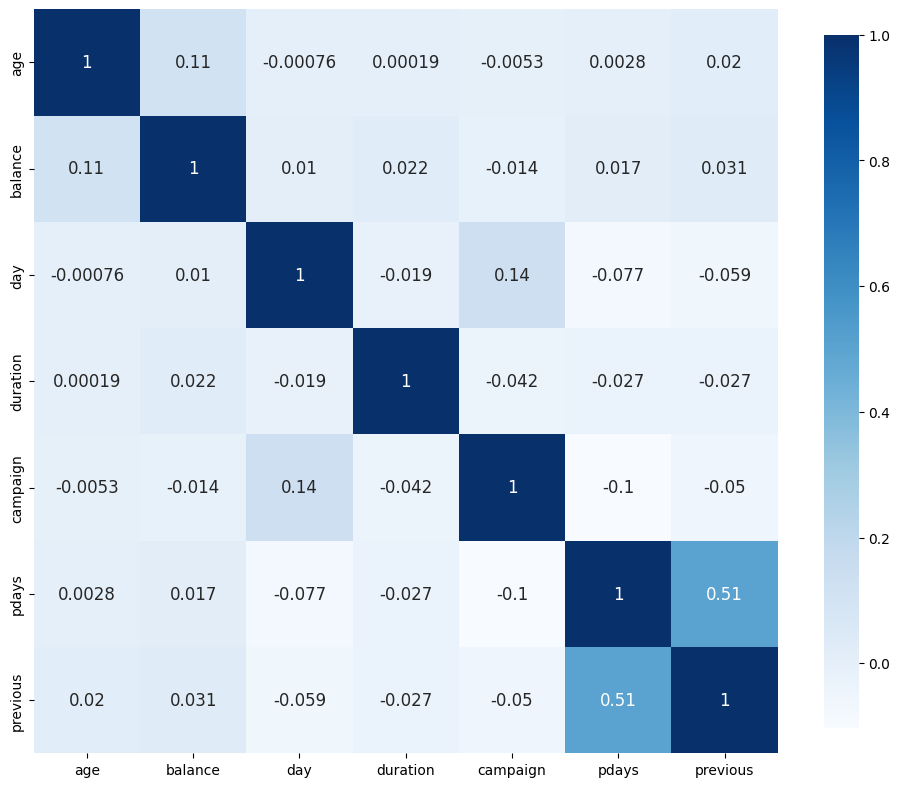

In [4]:
corr = df.select_dtypes(include=['int64']).corr
sns.heatmap(
		corr(),
		cmap = 'Blues',
		square = True,
		cbar_kws = {'shrink' : 0.9},
		ax = plt.subplots(figsize = (12, 10))[1],
		annot = True,
		annot_kws = {'fontsize' : 12}
)

## 觀察資料

Rows: 11162, Columns: 17

Analyzing Column: AGE (numerical)
Min: 18, Max: 95, Mean: 41.231947679627304, Std Dev: 11.913369192215526


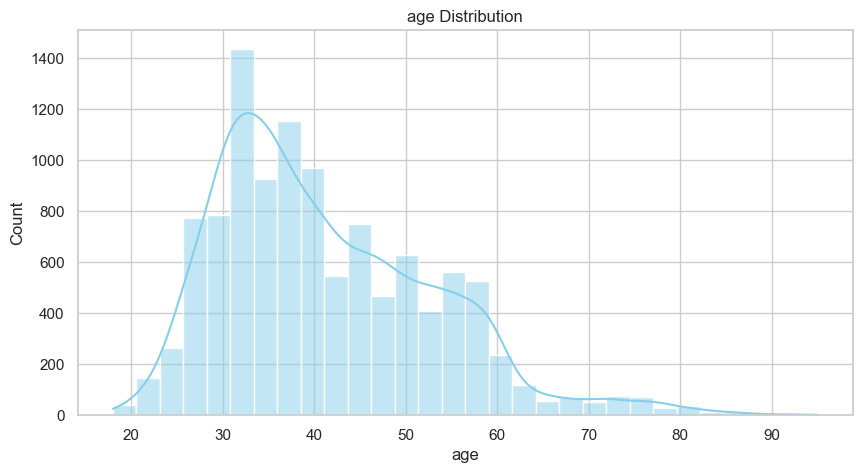


Analyzing Column: JOB (categorical)
job has 12 unique values.


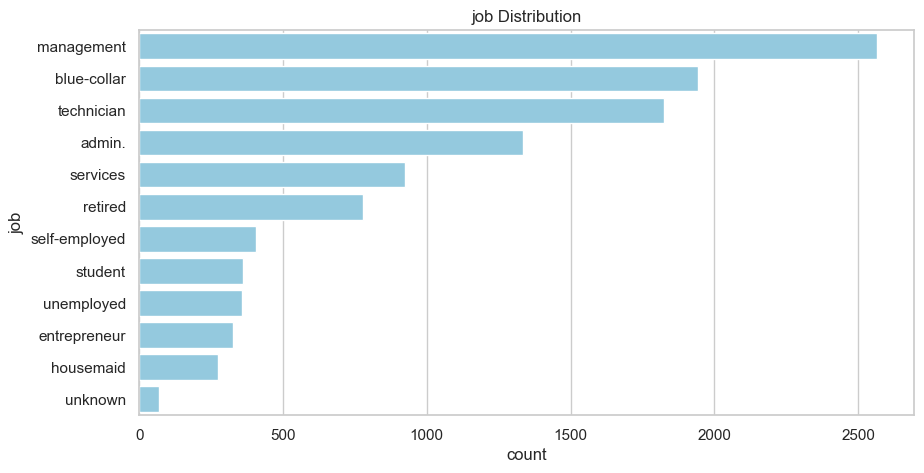


Analyzing Column: MARITAL (categorical)
marital has 3 unique values.


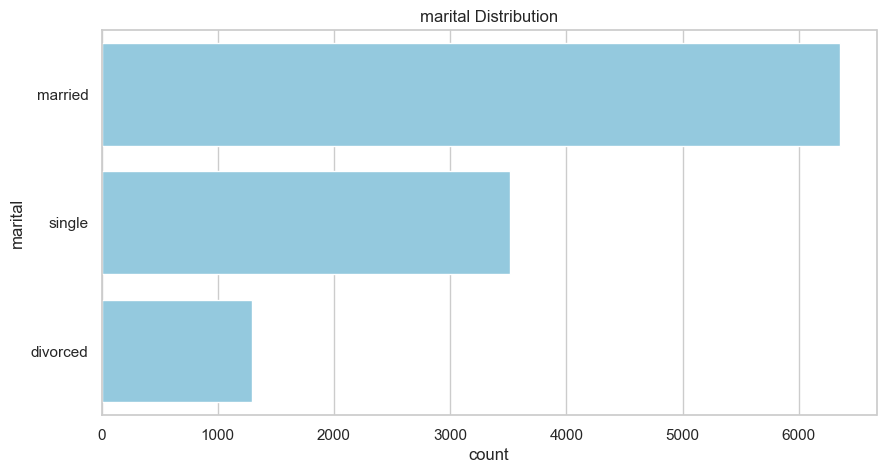


Analyzing Column: EDUCATION (categorical)
education has 4 unique values.


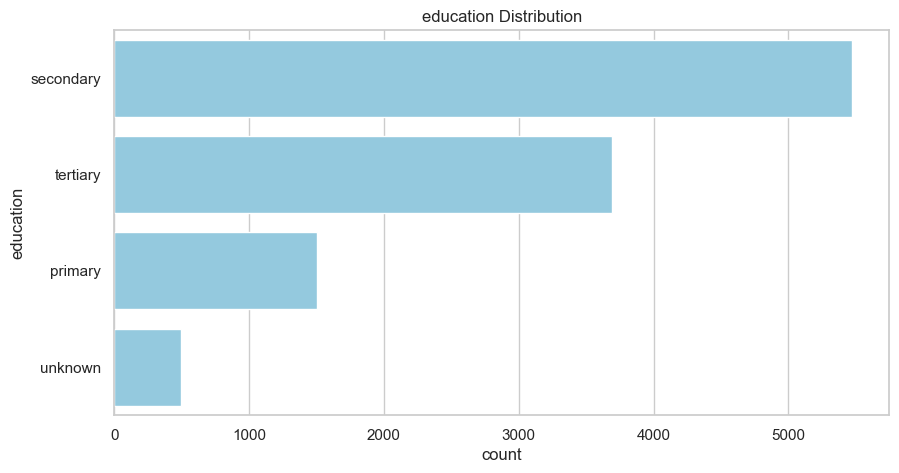


Analyzing Column: DEFAULT (categorical)
default has 2 unique values.


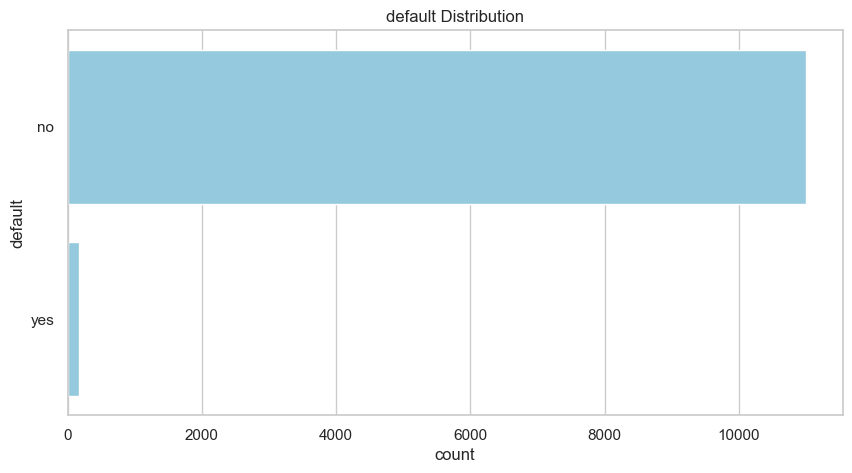


Analyzing Column: BALANCE (numerical)
Min: -6847, Max: 81204, Mean: 1528.5385235620856, Std Dev: 3225.413325946151


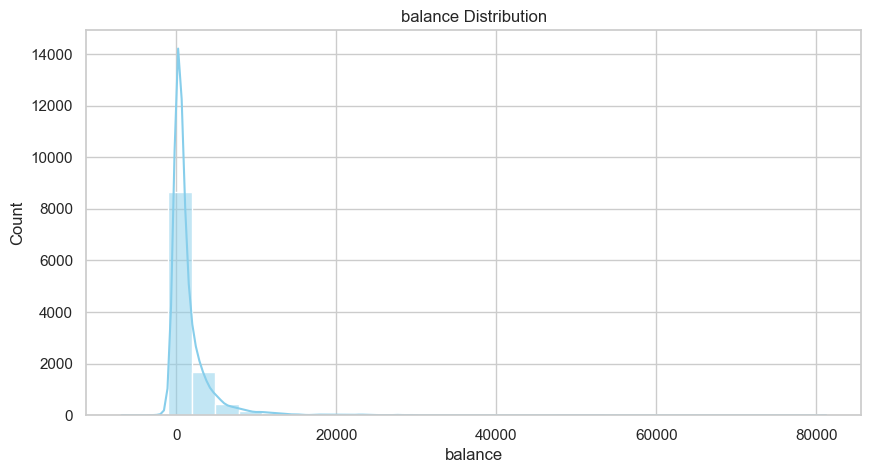


Analyzing Column: HOUSING (categorical)
housing has 2 unique values.


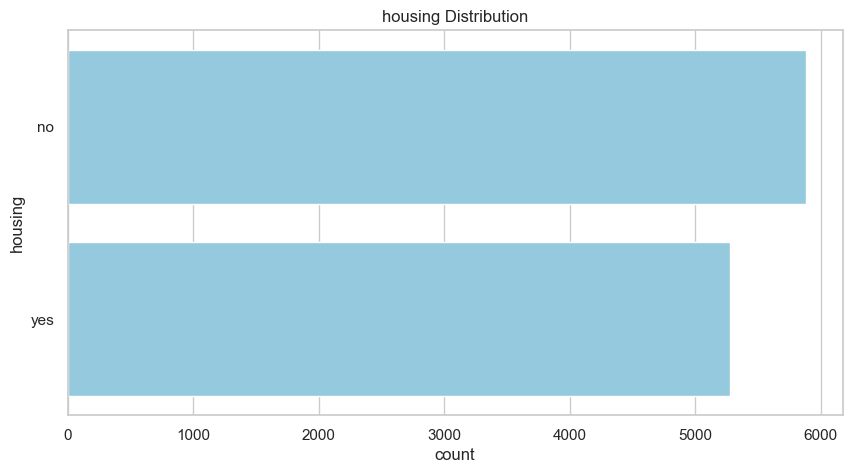


Analyzing Column: LOAN (categorical)
loan has 2 unique values.


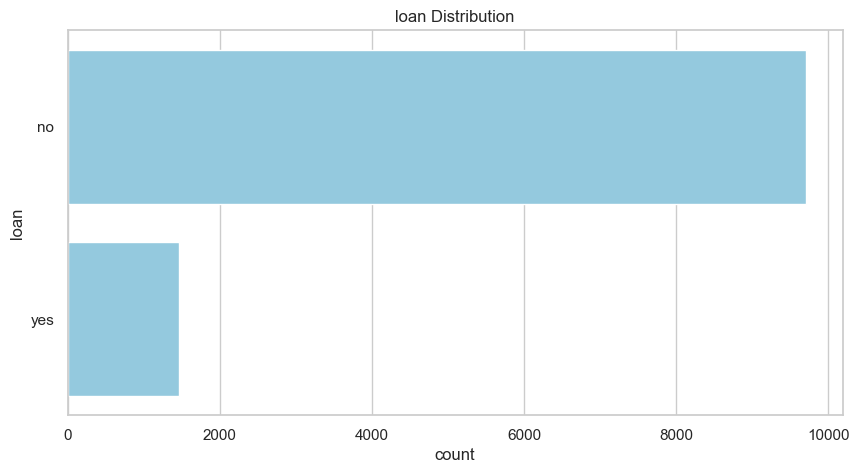


Analyzing Column: CONTACT (categorical)
contact has 3 unique values.


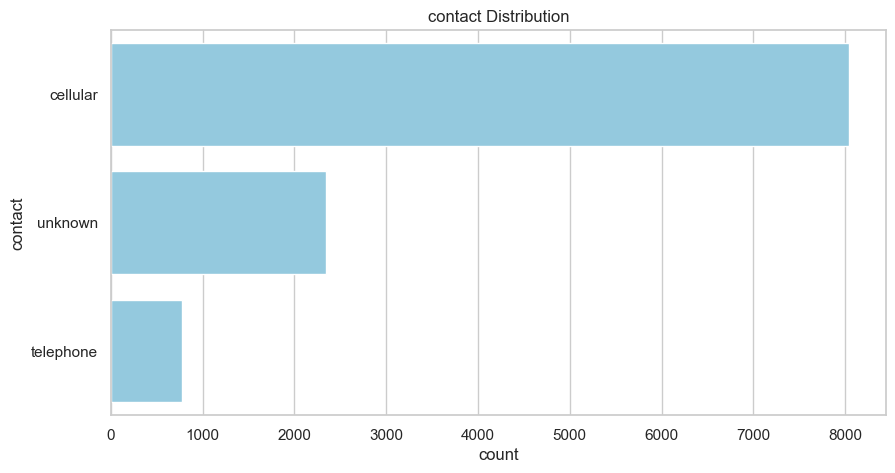


Analyzing Column: DAY (numerical)
Min: 1, Max: 31, Mean: 15.658036194230425, Std Dev: 8.420739541006451


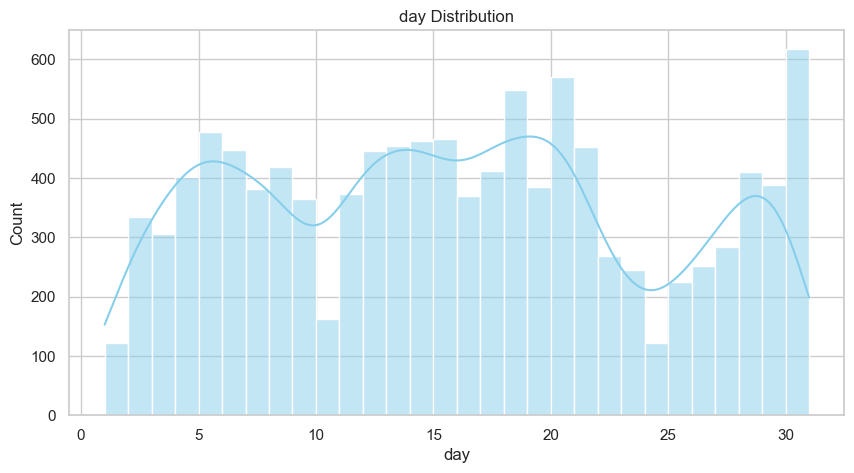


Analyzing Column: MONTH (categorical)
month has 12 unique values.


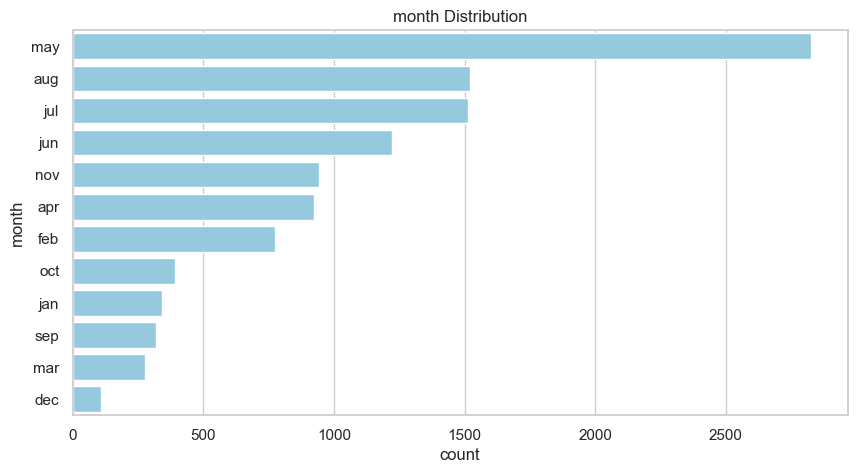


Analyzing Column: DURATION (numerical)
Min: 2, Max: 3881, Mean: 371.99381831213043, Std Dev: 347.12838571630584


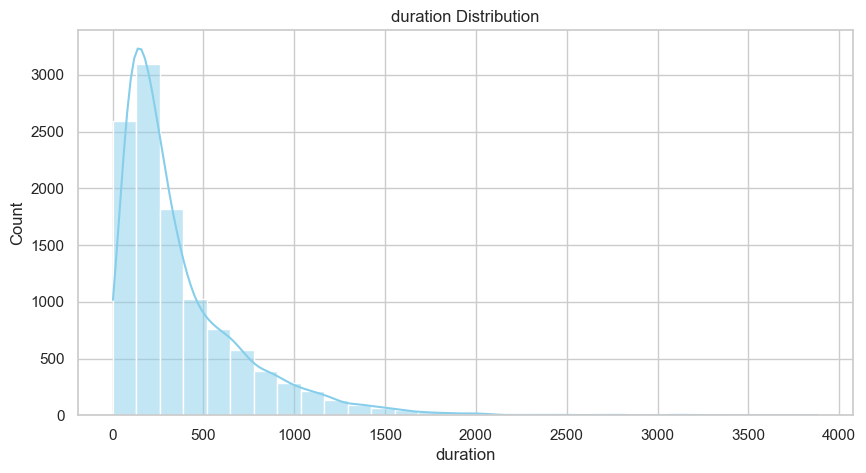


Analyzing Column: CAMPAIGN (numerical)
Min: 1, Max: 63, Mean: 2.508421429851281, Std Dev: 2.722077181661486


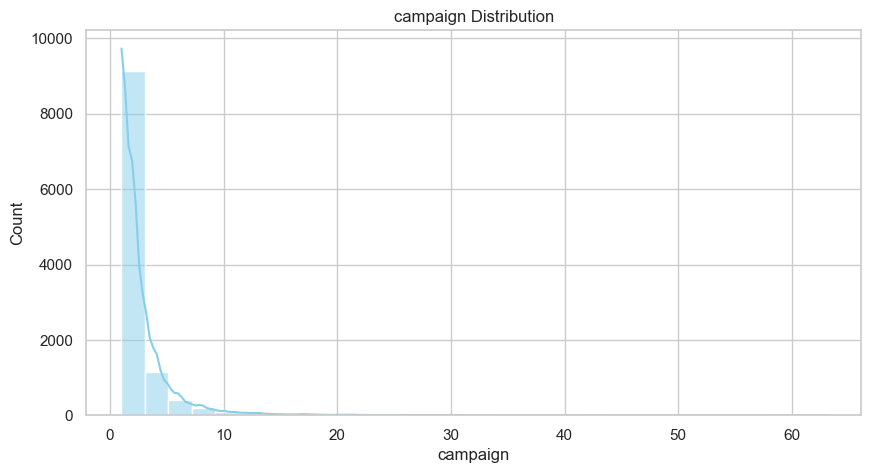


Analyzing Column: PDAYS (numerical)
Min: -1, Max: 854, Mean: 51.33040673714388, Std Dev: 108.75828197197696


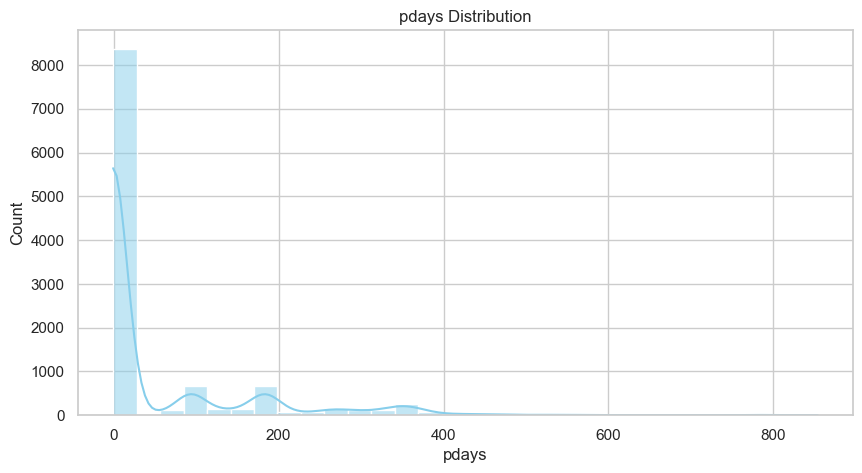


Analyzing Column: PREVIOUS (numerical)
Min: 0, Max: 58, Mean: 0.8325568894463358, Std Dev: 2.2920072186705047


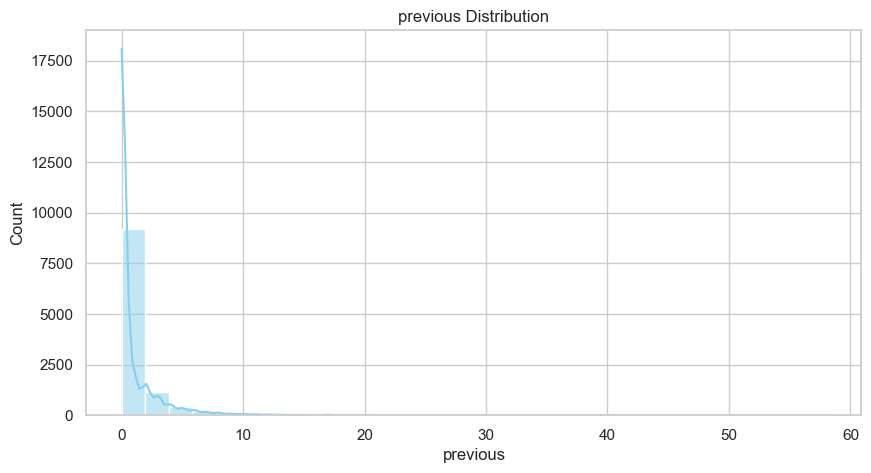


Analyzing Column: POUTCOME (categorical)
poutcome has 4 unique values.


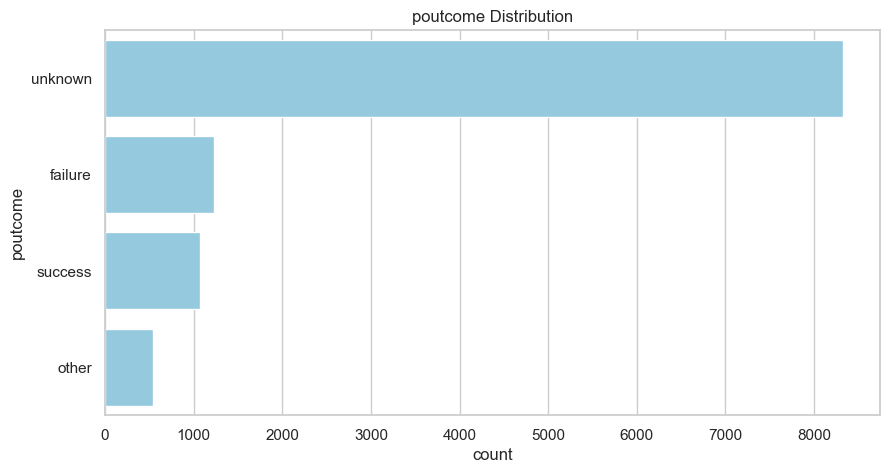


Analyzing Column: DEPOSIT (categorical)
deposit has 2 unique values.


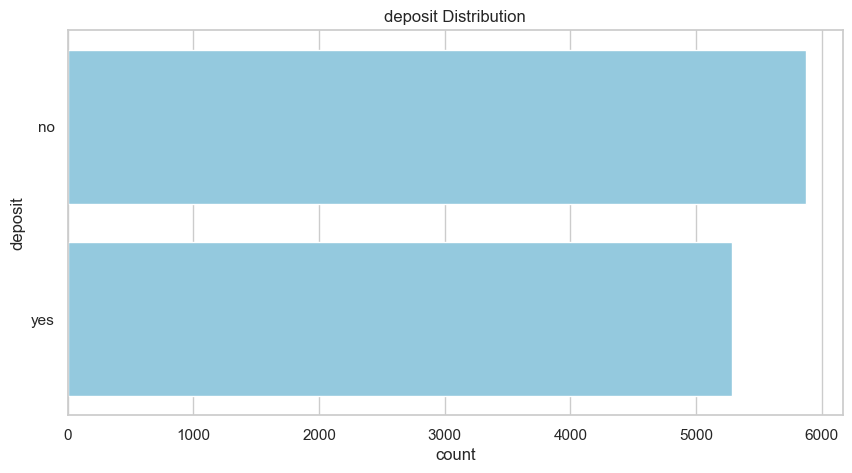

In [5]:
# 設置 Seaborn 主題和調色盤（以藍色調為主）
sns.set_theme(style="whitegrid", palette="Blues")

class EnhancedEDA:
    def __init__(self, data):
        self.data = data

    def overview(self):
        print(f"Rows: {self.data.shape[0]}, Columns: {self.data.shape[1]}")
        
    def plot_distribution(self, column):
        plt.figure(figsize=(10, 5))
        if self.data[column].dtype == 'object':
            sns.countplot(y=self.data[column], order=self.data[column].value_counts().index, color='skyblue')
        else:
            sns.histplot(self.data[column], bins=30, kde=True, color='skyblue')
        plt.title(f'{column} Distribution')
        plt.show()

    def detailed_analysis(self):
        for col in self.data.columns:
            if self.data[col].dtype == 'object':
                col_type = 'categorical'
                unique_vals = self.data[col].nunique()
                print(f'\nAnalyzing Column: {col.upper()} ({col_type})')
                print(f'{col} has {unique_vals} unique values.')
            else:
                col_type = 'numerical'
                min_val = self.data[col].min()
                max_val = self.data[col].max()
                mean_val = self.data[col].mean()
                std_val = self.data[col].std()

                print(f'\nAnalyzing Column: {col.upper()} ({col_type})')
                print(f'Min: {min_val}, Max: {max_val}, Mean: {mean_val}, Std Dev: {std_val}')
            
            self.plot_distribution(col)

    def run(self):
        self.overview()
        self.detailed_analysis()
        
eda = EnhancedEDA(df)
eda.run()

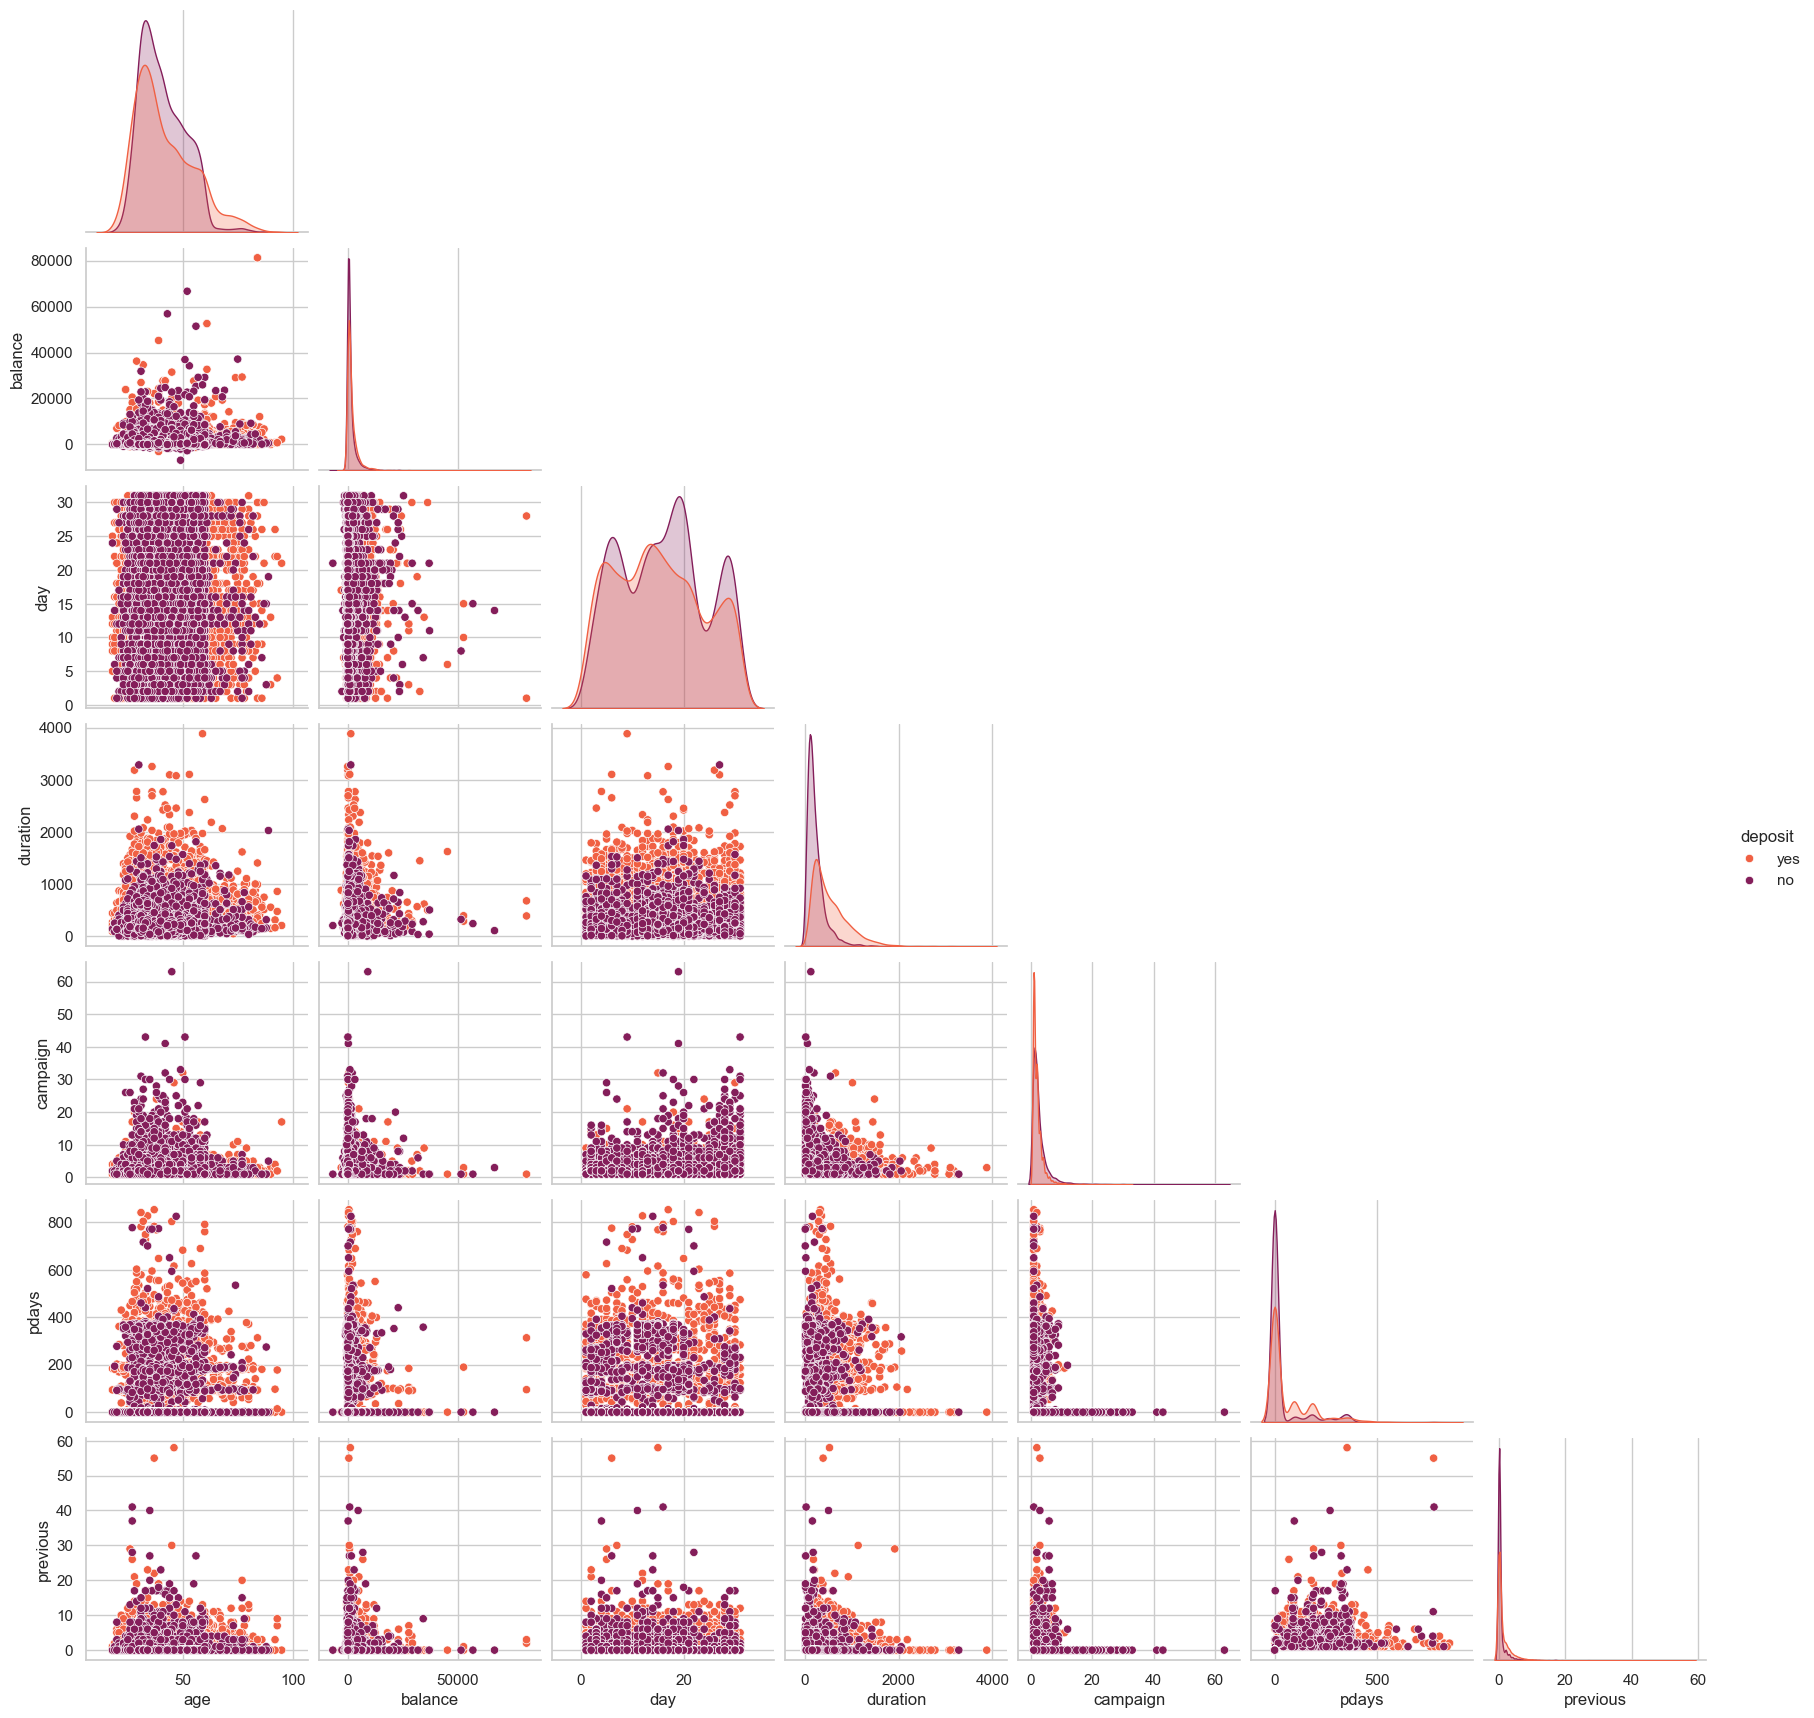

In [6]:
sns.pairplot(df, hue='deposit', corner=True, palette='rocket_r')

/var/folders/6w/6fp4bzvd51z4q5lgb62zhjph0000gn/T/ipykernel_48360/1115535961.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


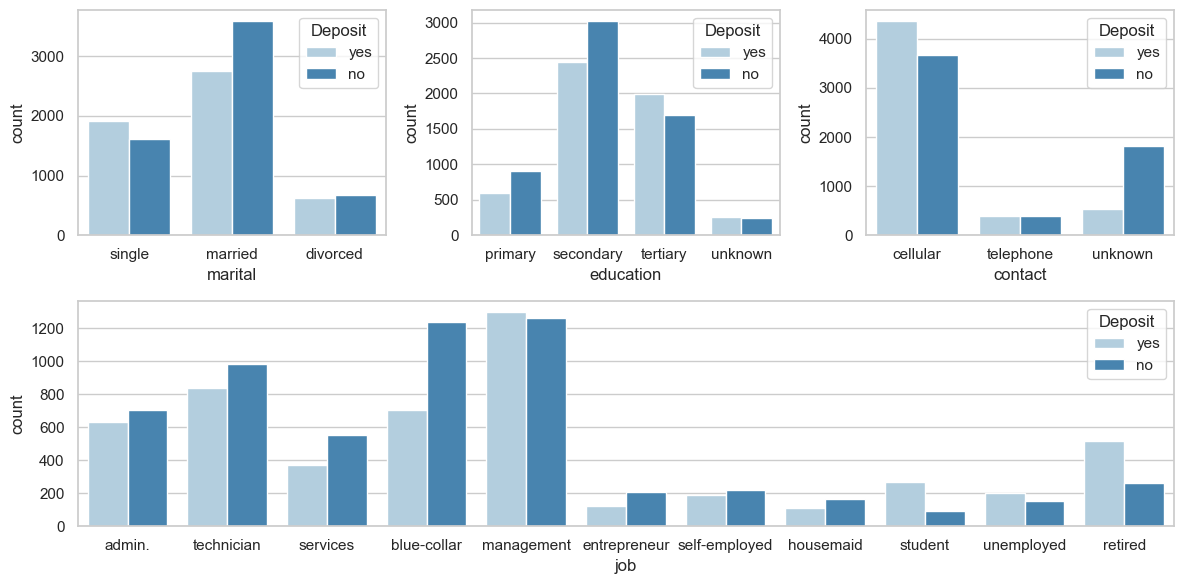

In [7]:
cols = ['marital', 'education', 'contact']
order = [['single', 'married', 'divorced'], 
         ['primary', 'secondary', 'tertiary', 'unknown'], 
         ['cellular', 'telephone', 'unknown'], 
         ['admin.', 'technician', 'services',  'blue-collar', 'management', 'entrepreneur', 'self-employed', 'housemaid', 'student', 'unemployed', 'retired'],
         ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']]
n_rows = 2
n_cols = 3

# 使用 GridSpec 來定義子圖佈局
fig = plt.figure(constrained_layout=True, figsize=(n_cols * 4, n_rows * 3))
gs = fig.add_gridspec(n_rows, n_cols)

# 第一行三個圖表
for c in range(n_cols):
    ax = fig.add_subplot(gs[0, c])  # 第一行的第 c 列
    sns.countplot(x=df[cols[c]], hue=df['deposit'], ax=ax, palette='Blues', order=order[c])
    ax.legend(title='Deposit', loc='upper right')

# 第二行合併三列，顯示職業圖表
ax_job = fig.add_subplot(gs[1, :])  # 第二行跨三列
sns.countplot(x='job', hue='deposit', data=df, ax=ax_job, palette='Blues', order=order[3])
ax_job.legend(title='Deposit', loc='upper right')

plt.tight_layout()

<Axes: xlabel='job', ylabel='balance'>

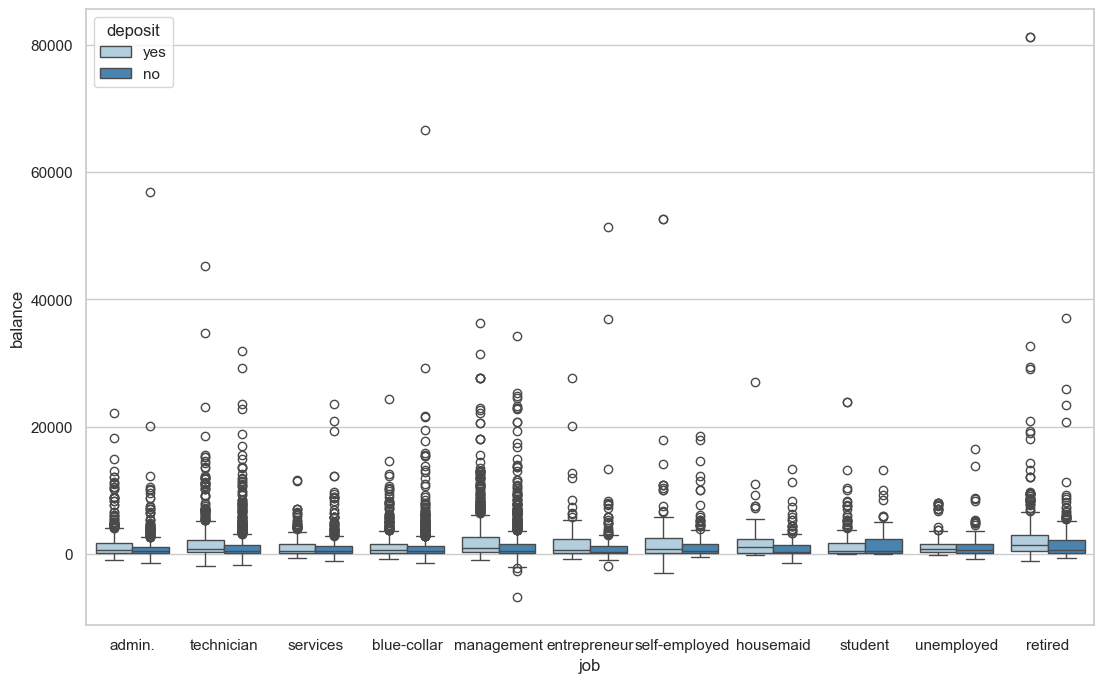

In [8]:
fig, ax = plt.subplots(figsize=(13, 8))
sns.boxplot(x='job', y='balance', hue='deposit', data=df, order=order[3], palette='Blues')

針對人數較多的管理職、藍領階級、科技人員進行分析

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1800x600 with 0 Axes>

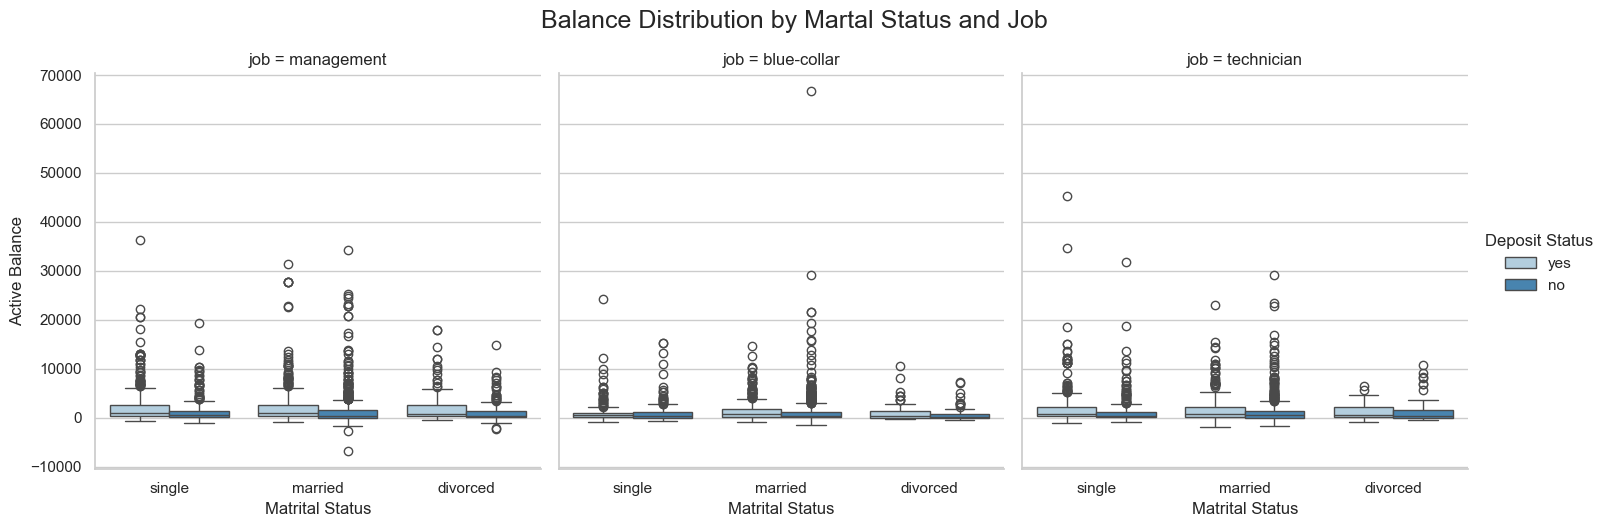

In [9]:
plt.figure(figsize=(18,6))

g = sns.FacetGrid(df[df['job'].isin(['management', 'blue-collar', 'technician'])],
col='job',
col_order = ['management', 'blue-collar', 'technician'],
height=5, aspect=1)

g.map(sns.boxplot, 'marital', 'balance', 'deposit', palette='Blues', showfliers=True)

g.fig.suptitle('Balance Distribution by Martal Status and Job', fontsize=18, y=1.05)
g.set_axis_labels('Matrital Status', 'Active Balance')
g.add_legend(title='Deposit Status')

sns.despine()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1800x600 with 0 Axes>

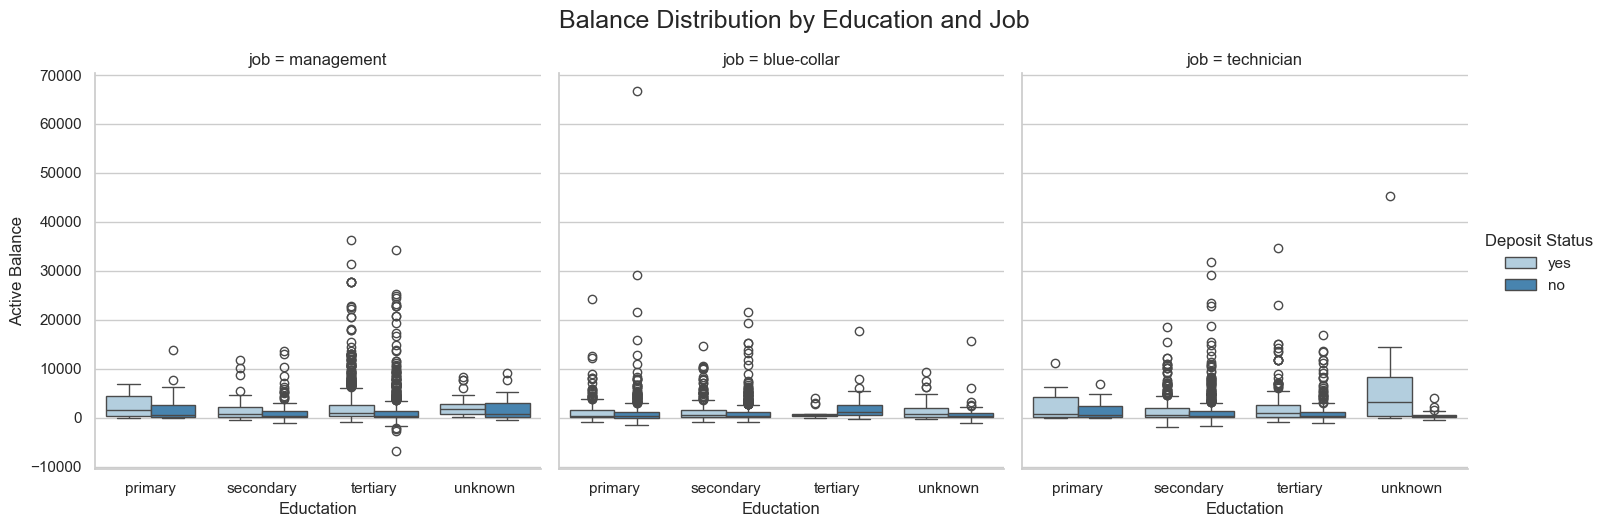

In [10]:
plt.figure(figsize=(18,6))

g = sns.FacetGrid(df[df['job'].isin(['management', 'blue-collar', 'technician'])],
col='job',
col_order = ['management', 'blue-collar', 'technician'],
height=5, aspect=1)

g.map(sns.boxplot, 'education', 'balance', 'deposit', palette='Blues', showfliers=True, order=order[1])

g.fig.suptitle('Balance Distribution by Education and Job', fontsize=18, y=1.05)
g.set_axis_labels('Eductation', 'Active Balance')
g.add_legend(title='Deposit Status')

sns.despine()
plt.show()

<Axes: xlabel='age', ylabel='job'>

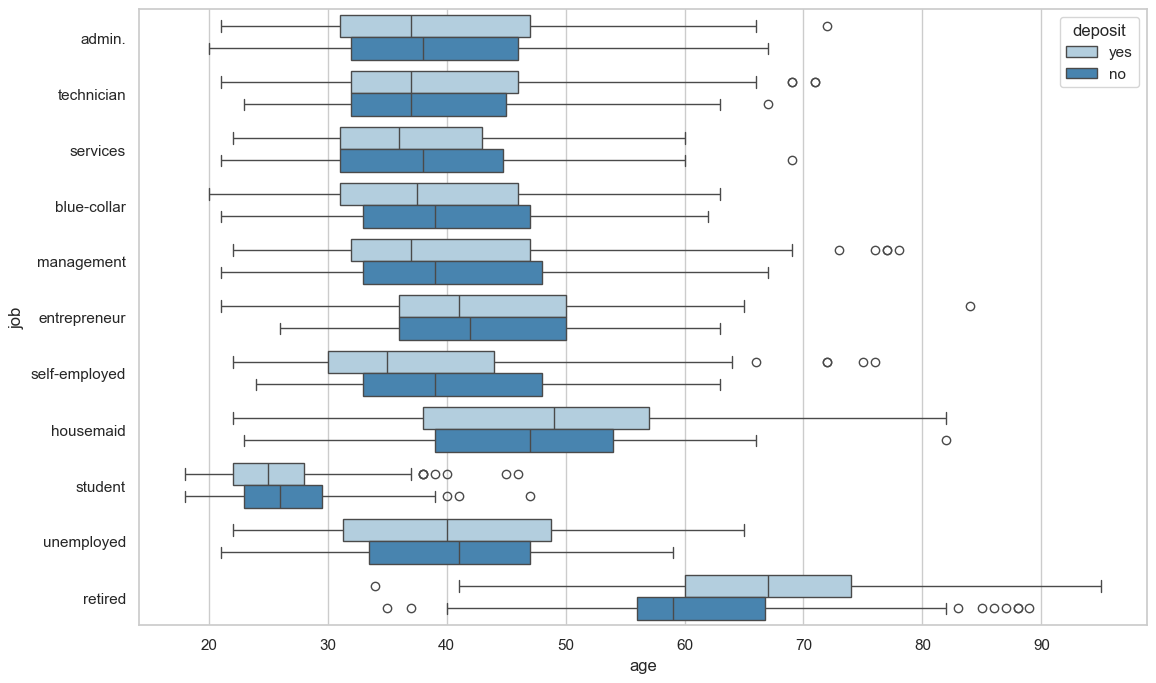

In [11]:
fig, ax = plt.subplots(figsize=(13, 8))
sns.boxplot(x='age', y='job', hue='deposit', data=df, order=order[3], palette='Blues', orient='h')

可以看出 30-60 歲以內的客戶定期存款的人較少，大多集中在 30 歲以下或是 60 歲以上的人 30 - 60 歲之間有定期存款的，多為存款較高的人，且只有少數幾個人的存款超過 2 萬元

Text(0.5, 1.0, 'Distribution of Balance by Age')

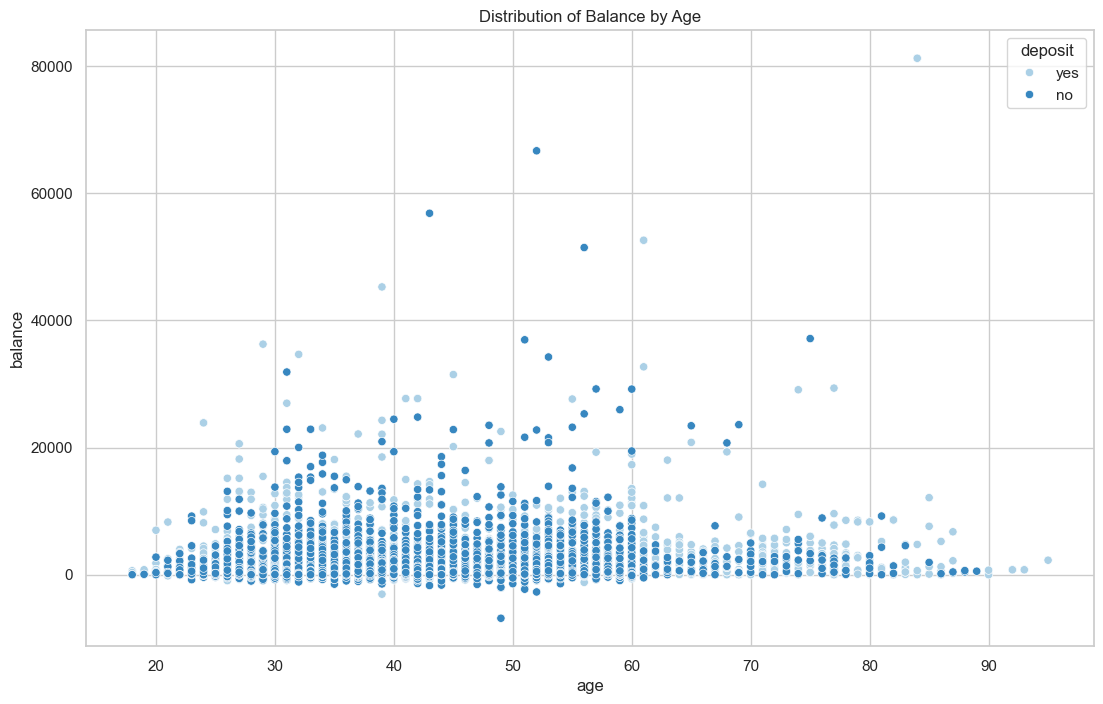

In [12]:
fig, ax = plt.subplots(figsize=(13, 8))
sns.scatterplot(x='age', y='balance', hue='deposit', data=df, palette='Blues')
plt.title('Distribution of Balance by Age')

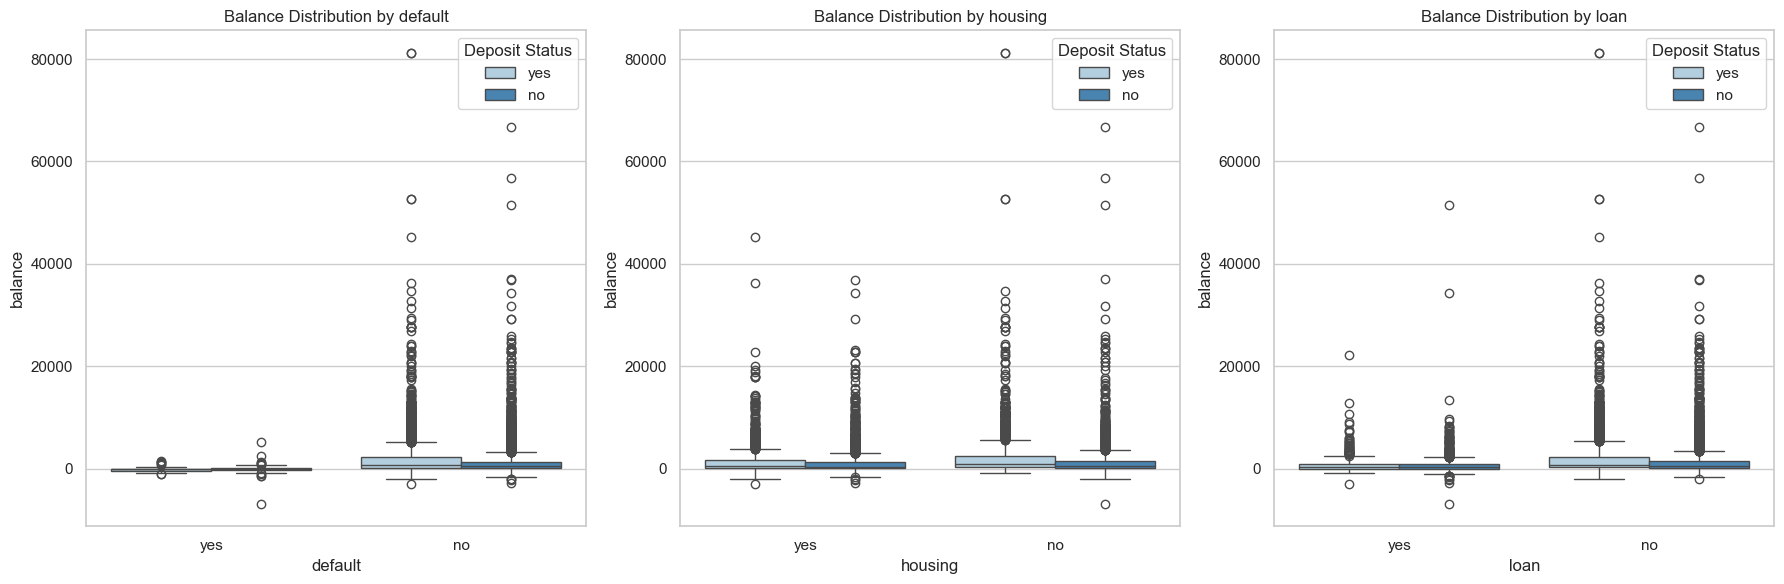

In [13]:
cols = ['default', 'housing', 'loan']  # 替換為要比較的欄位
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
yes_no_order =['yes', 'no']

for i, col in enumerate(cols):
    sns.boxplot(x=col, y='balance', hue='deposit', data=df, ax=axs[i], palette='Blues', order=yes_no_order)
    axs[i].set_title(f'Balance Distribution by {col}')
    axs[i].legend(title='Deposit Status', loc='upper right')

plt.tight_layout()
plt.show()

/var/folders/6w/6fp4bzvd51z4q5lgb62zhjph0000gn/T/ipykernel_48360/1022480543.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=col, y='age', data=df, ax=axs[i], palette='Blues', order=yes_no_order, inner='box')
/var/folders/6w/6fp4bzvd51z4q5lgb62zhjph0000gn/T/ipykernel_48360/1022480543.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=col, y='age', data=df, ax=axs[i], palette='Blues', order=yes_no_order, inner='box')
/var/folders/6w/6fp4bzvd51z4q5lgb62zhjph0000gn/T/ipykernel_48360/1022480543.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


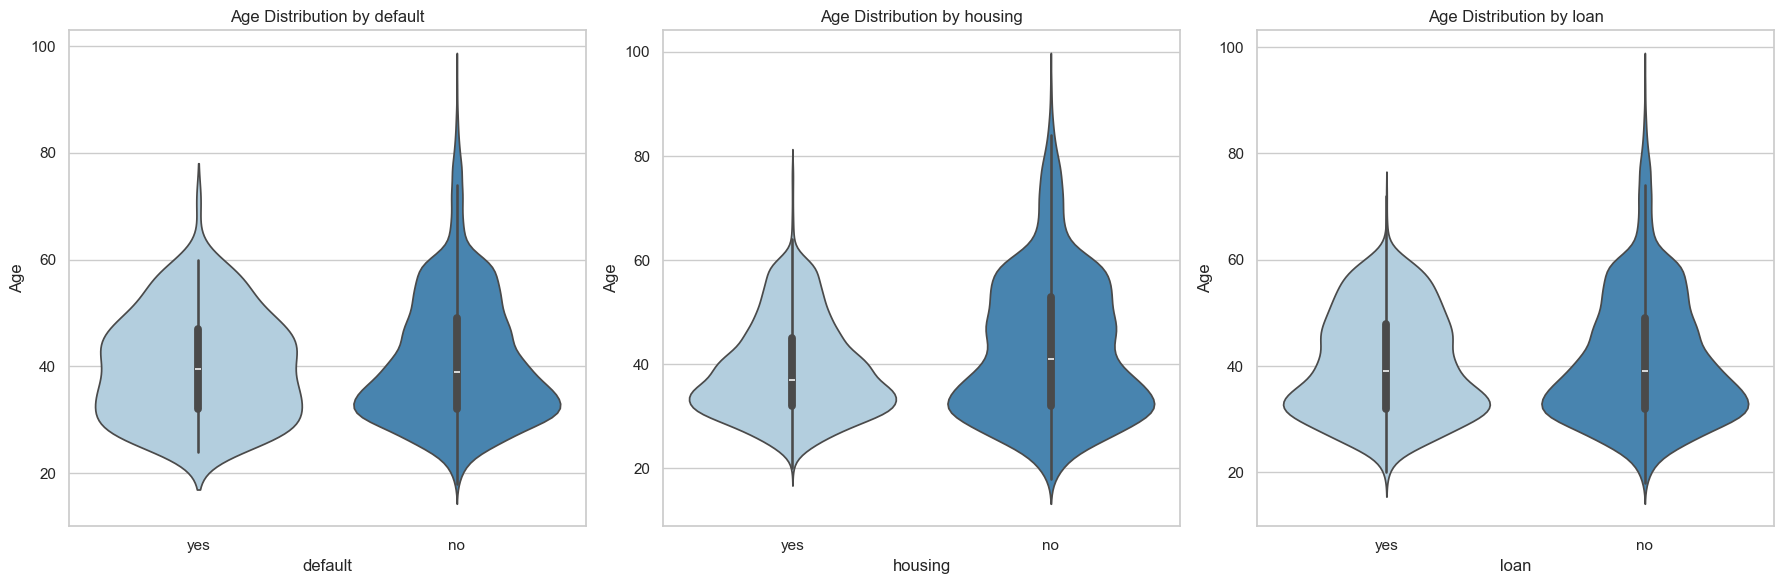

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(cols):
    sns.violinplot(x=col, y='age', data=df, ax=axs[i], palette='Blues', order=yes_no_order, inner='box')
    axs[i].set_title(f'Age Distribution by {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel("Age")

plt.tight_layout()
plt.show()


## 特徵工程

In [15]:
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

我們可以看到 job 中，unknow 的人數有 70 人，只佔11,162筆資料的 0.6 %，對於分析上沒有幫助，因此選擇將他移除。

In [16]:
df = df.drop(df.loc[df["job"] == "unknown"].index)
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: count, dtype: int64

### LabelEncoding
我們可以發現 default, housing, loan, deposit 的值為 yes, no，用 unique 確認是否有包含其他的值，確定這 4 個欄位中的值，皆只有 yes, no，因此我們進行 labelEncoding 方便之後進行分析。

In [17]:
print(df['default'].unique())
print(df['housing'].unique())
print(df['loan'].unique())
print(df['deposit'].unique())

['no' 'yes']
['yes' 'no']
['no' 'yes']
['yes' 'no']


In [18]:
def labelEncoding(x):
    yn_encoding = {'no':0, 'yes':1}
    return yn_encoding.get(x)

df['default'] = df['default'].map(labelEncoding)
df['housing'] = df['housing'].map(labelEncoding)
df['loan'] = df['loan'].map(labelEncoding)
df['deposit'] = df['deposit'].map(labelEncoding)

### One Hot Encoding

In [19]:
df_job = pd.get_dummies(df['job'], prefix='job_', dtype='int')
df_marital = pd.get_dummies(df['marital'], prefix='marital_', dtype='int')
df_education = pd.get_dummies(df['education'], prefix='education_', dtype='int')
df_contact = pd.get_dummies(df['contact'], prefix='contact_', dtype='int')
df_month = pd.get_dummies(df['month'], prefix='month_', dtype='int')
df_poutcome = pd.get_dummies(df['poutcome'], prefix='poutcome_', dtype='int')

df = df.join(df_job)
df = df.join(df_marital)
df = df.join(df_education)
df = df.join(df_contact)
df = df.join(df_month)
df = df.join(df_poutcome)
df

,age,job,marital,education,default,balance,housing,loan,contact,day,...,month__jun,month__mar,month__may,month__nov,month__oct,month__sep,poutcome__failure,poutcome__other,poutcome__success,poutcome__unknown
0,59,admin.,married,secondary,0,2343,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
1,56,admin.,married,secondary,0,45,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
2,41,technician,married,secondary,0,1270,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
3,55,services,married,secondary,0,2476,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
4,54,admin.,married,tertiary,0,184,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,0,1,1,0,cellular,20,...,0,0,0,0,0,0,0,0,0,1
11158,39,services,married,secondary,0,733,0,0,unknown,16,...,1,0,0,0,0,0,0,0,0,1
11159,32,technician,single,secondary,0,29,0,0,cellular,19,...,0,0,0,0,0,0,0,0,0,1
11160,43,technician,married,secondary,0,0,0,1,cellular,8,...,0,0,1,0,0,0,1,0,0,0


## Baseline

進行各模型的結果

In [20]:
columns_X = ['age', 'default', 'balance', 'housing', 'loan', 
            'day', 'duration', 'campaign', 'pdays', 'previous',
            'job__admin.', 'job__blue-collar',
            'job__entrepreneur', 'job__housemaid', 'job__management',
            'job__retired', 'job__self-employed', 'job__services', 'job__student',
            'job__technician', 'job__unemployed', 'marital__divorced',
            'marital__married', 'marital__single', 'education__primary',
            'education__secondary', 'education__tertiary', 'education__unknown',
            'contact__cellular', 'contact__telephone', 'contact__unknown',
            'month__apr', 'month__aug', 'month__dec', 'month__feb', 'month__jan',
            'month__jul', 'month__jun', 'month__mar', 'month__may', 'month__nov',
            'month__oct', 'month__sep', 'poutcome__failure', 'poutcome__other',
            'poutcome__success', 'poutcome__unknown']
columns_y = ['deposit']

X_train = df[columns_X]
y_train = df[columns_y]

In [21]:
dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=18),
    "Neural Net": MLPClassifier(alpha=1),
    "Naive Bayes": GaussianNB(),
    'XGBoost': XGBClassifier()
}

no_classifiers = len(dict_classifiers.keys())

In [22]:
def batch_classify(X_train, Y_train, verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,3)), columns = ['classifier', 'train_score', 'training_time'])
    count = 0
    for key, classifier in dict_classifiers.items():
        t_start = time.perf_counter() # 使用 perf_counter 替代 clock
        classifier.fit(X_train, Y_train)
        t_end = time.perf_counter()
        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        df_results.loc[count,'classifier'] = key
        df_results.loc[count,'train_score'] = train_score
        df_results.loc[count,'training_time'] = t_diff
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=key, f=t_diff))
        count+=1
    return df_results

df_results = batch_classify(X_train, y_train)
df_results.sort_values(by='train_score', ascending=False)

trained Logistic Regression in 0.11 s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/6w/6fp4bzvd51z4q5lgb62zhjph0000gn/T/ipykernel_48360/395473141.py:10: FutureWarning: Setting an item of incompatible dtype is deprecat

trained Nearest Neighbors in 0.00 s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


trained Linear SVM in 3.15 s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


trained Gradient Boosting Classifier in 2.05 s
trained Decision Tree in 0.10 s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


trained Random Forest in 0.22 s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


trained Neural Net in 0.90 s
trained Naive Bayes in 0.01 s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


trained XGBoost in 0.20 s


,classifier,train_score,training_time
4,Decision Tree,1.000000,0.097451
5,Random Forest,0.997656,0.215023
8,XGBoost,0.949062,0.200997
3,Gradient Boosting Classifier,0.856744,2.047498
1,Nearest Neighbors,0.820141,0.002970
0,Logistic Regression,0.798774,0.105829
2,Linear SVM,0.740894,3.152402
7,Naive Bayes,0.733231,0.008517
6,Neural Net,0.670303,0.899676


製作訓練集

In [23]:
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train.values, test_size=0.2, random_state=42)

### SMOTE
先進行 SMOTE 來平衡類別分布，使得訓練集中少數類別樣本數量增加

In [24]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_split, y_train_split)

### StrandardScaler
進行 StandardScaler，只針對訓練集，避免資料過於擬合

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled) # 計算訓練集的標準化參數
X_test_scaled = scaler.transform(X_test_split)     # 應用訓練集的標準化參數
print('SMOTE後的類別分布:', pd.Series(y_resampled).value_counts())

SMOTE後的類別分布: 1    4696
0    4696
Name: count, dtype: int64


平均分布及標準化後，在進行一次機器學習

In [26]:
df_results = batch_classify(X_train_scaled, y_resampled)
df_results.sort_values(by='train_score', ascending=False)

trained Logistic Regression in 0.01 s


/var/folders/6w/6fp4bzvd51z4q5lgb62zhjph0000gn/T/ipykernel_48360/395473141.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Logistic Regression' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_results.loc[count,'classifier'] = key


trained Nearest Neighbors in 0.00 s
trained Linear SVM in 1.78 s
trained Gradient Boosting Classifier in 1.76 s
trained Decision Tree in 0.08 s
trained Random Forest in 0.18 s
trained Neural Net in 1.56 s
trained Naive Bayes in 0.00 s
trained XGBoost in 0.17 s


,classifier,train_score,training_time
4,Decision Tree,1.000000,0.081393
5,Random Forest,0.998190,0.177593
8,XGBoost,0.960711,0.170676
2,Linear SVM,0.891078,1.783500
6,Neural Net,0.883837,1.561753
3,Gradient Boosting Classifier,0.868931,1.758710
1,Nearest Neighbors,0.844336,0.001421
0,Logistic Regression,0.837947,0.013768
7,Naive Bayes,0.707730,0.004458


## Cross Validation
進行交叉分析，scoring 預設為 Accuracy

In [27]:
# Logistic Regression
log_reg = LogisticRegression()
log_scores = cross_val_score(log_reg, X_train_scaled, y_resampled, cv=5)
log_reg_mean = log_scores.mean()

# SVC
svc_clf = SVC()
svc_scores = cross_val_score(svc_clf, X_train_scaled, y_resampled, cv=5)
svc_mean = svc_scores.mean()

# KNearestNeighbors
knn_clf = KNeighborsClassifier()
knn_scores = cross_val_score(knn_clf, X_train_scaled, y_resampled, cv=5)
knn_mean = knn_scores.mean()

# Decision Tree
tree_clf = tree.DecisionTreeClassifier()
tree_scores = cross_val_score(tree_clf, X_train_scaled, y_resampled, cv=5)
tree_mean = tree_scores.mean()

# Gradient Boosting Classifier
grad_clf = GradientBoostingClassifier()
grad_scores = cross_val_score(grad_clf, X_train_scaled, y_resampled, cv=5)
grad_mean = grad_scores.mean()

# Random Forest Classifier
rand_clf = RandomForestClassifier(n_estimators=18)
rand_scores = cross_val_score(rand_clf, X_train_scaled, y_resampled, cv=5)
rand_mean = rand_scores.mean()

# NeuralNet Classifier
neural_clf = MLPClassifier(alpha=1)
neural_scores = cross_val_score(neural_clf, X_train_scaled, y_resampled, cv=5)
neural_mean = neural_scores.mean()

# Naives Bayes
nav_clf = GaussianNB()
nav_scores = cross_val_score(nav_clf, X_train_scaled, y_resampled, cv=5)
nav_mean = neural_scores.mean()

# XGB Classifier
xgbc_clf = XGBClassifier()
xgbc_scores = cross_val_score(xgbc_clf, X_train_scaled, y_resampled, cv=5)
xgbc_mean = xgbc_scores.mean()

In [28]:
# Create a Dataframe with the results.
d = {'Classifiers': ['Logistic Reg.', 'SVC', 'KNN', 'Dec Tree', 'Grad B CLF', 'Rand FC', 'Neural Classifier', 'Naives Bayes', 'XGBoost'], 
    'Crossval Mean Scores': [log_reg_mean, svc_mean, knn_mean, tree_mean, grad_mean, rand_mean, neural_mean, nav_mean, xgbc_mean]}

result_df = pd.DataFrame(data=d)
result_df = result_df.sort_values(by=['Crossval Mean Scores'], ascending=False)
result_df

,Classifiers,Crossval Mean Scores
8,XGBoost,0.857856
6,Neural Classifier,0.852214
7,Naives Bayes,0.852214
4,Grad B CLF,0.851042
1,SVC,0.843483
5,Rand FC,0.843058
0,Logistic Reg.,0.821869
3,Dec Tree,0.796316
2,KNN,0.757667


在模型學習與交叉驗證下 XGBoost 的效果都不錯，因此我選定他來做進一步的預測。

In [29]:
xgbc_clf.fit(X_train_scaled, y_resampled)
y_pred = xgbc_clf.predict(X_test_scaled)
y_pred = cross_val_predict(xgbc_clf, X_train_scaled, y_resampled, cv=5)

## Confusion Matrix

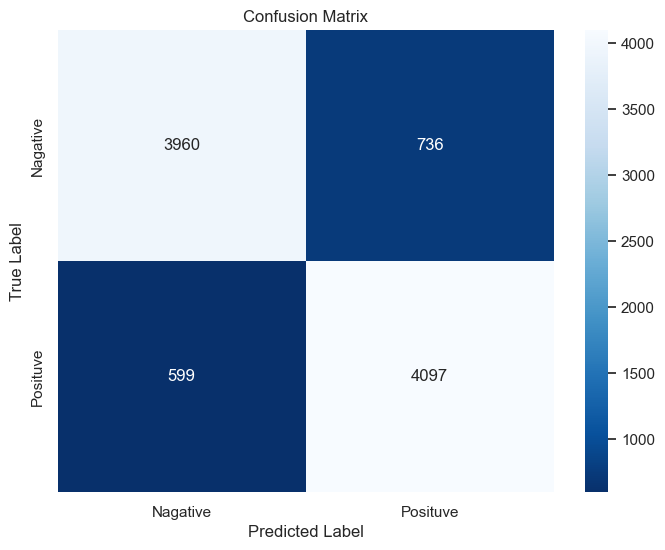

Accuracy Score: 0.8578577512776832
Precision Score: 0.8477136354231326
Recall Score: 0.8724446337308348
F1 Score: 0.8599013537621996


In [30]:
# 計算混肴矩陣
cm = confusion_matrix(y_resampled, y_pred)

# 可視化混肴矩陣
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r',
            xticklabels=['Nagative', 'Posituve'],
            yticklabels=['Nagative', 'Posituve'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgbc_clf.classes_)
# disp.plot(cmap='Blues')
# plt.show()

print('Accuracy Score:', accuracy_score(y_resampled, y_pred))
print('Precision Score:', precision_score(y_resampled, y_pred))
print('Recall Score:', recall_score(y_resampled, y_pred))
print('F1 Score:', f1_score(y_resampled, y_pred))

## Precision-Recall

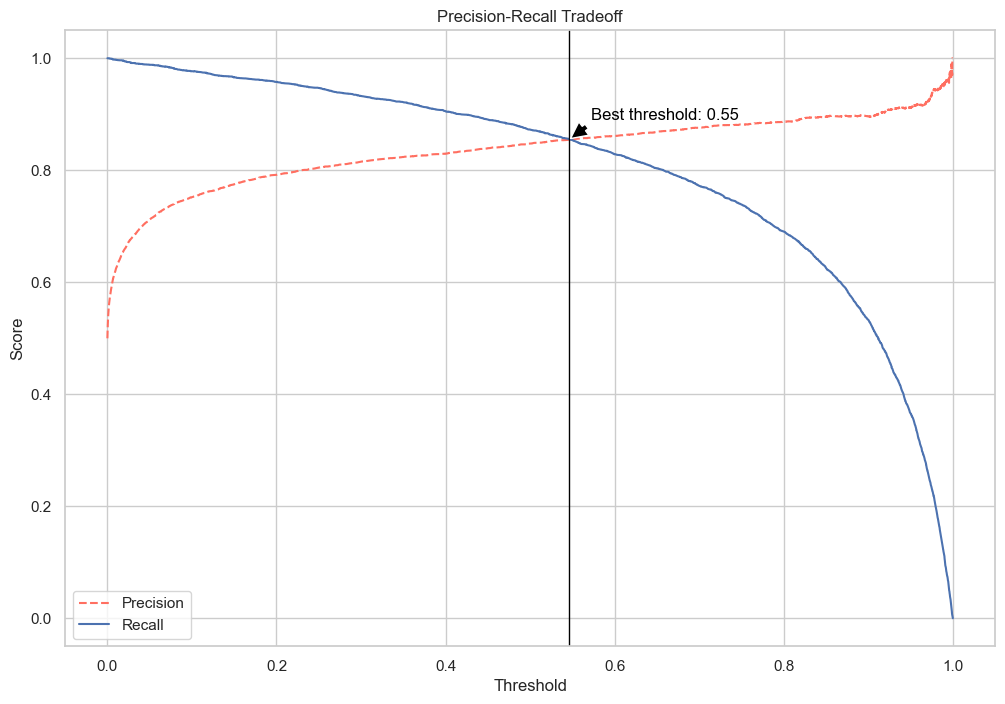

In [31]:
# 取得正例的預測機率(預測分數)，取得正例的分數(第二列)
y_scores = cross_val_predict(xgbc_clf, X_train_scaled, y_resampled, cv=5, method='predict_proba')[:,1]

#計算 precision 和 recall
precisions, recalls, thresholds = precision_recall_curve(y_resampled, y_scores)

# 繪製 Precision-Recall 曲線
plt.figure(figsize=(12, 8))
sns.lineplot(x=thresholds, y=precisions[:-1], label='Precision', linestyle='--', color='#FF6F61')
sns.lineplot(x=thresholds, y=recalls[:-1], label='Recall', linestyle='-', color='#4C72B0')

plt.title('Precision-Recall Tradeoff')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='best')

# 找出最佳 threshold，例如取 precision 和 recall 差值最小的點（可以根據需求改變方法）
best_index = abs(precisions - recalls).argmin()
best_threshold = thresholds[best_index]
best_precision = precisions[best_index]
best_recall = recalls[best_index]

# 在圖表上標記最佳 threshold
plt.axvline(x=best_threshold, color="black", linestyle="-", linewidth=1)
plt.annotate(f'Best threshold: {best_threshold:.2f}', 
                xy=(best_threshold, best_precision), 
                xytext=(best_threshold + 15, best_precision + 13),
                textcoords="offset points",
                arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=12, color='k')
plt.show()

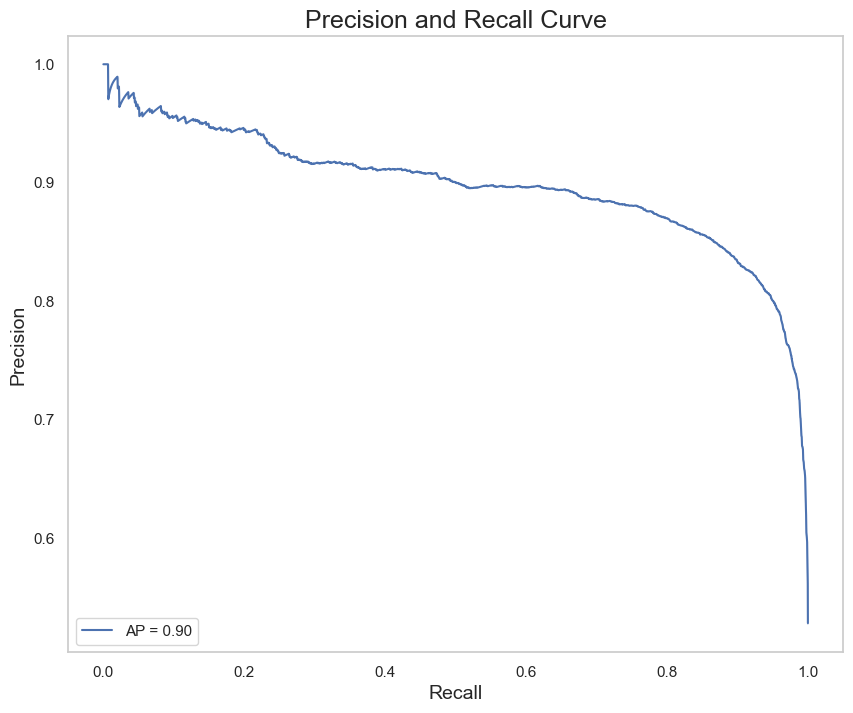

In [43]:
precision, recall, thresholds = precision_recall_curve(y_resampled, y_scores)
ap_score = average_precision_score(y_resampled, y_scores)

# 使用seaborn繪製曲線
plt.figure(figsize=(10, 8))
sns.lineplot(x=recall, y=precision, color="b", label=f'AP = {ap_score:.2f}')
plt.title("Precision and Recall Curve", fontsize=18)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.legend(loc='lower left')
plt.grid()
plt.show()

## ROC Curve

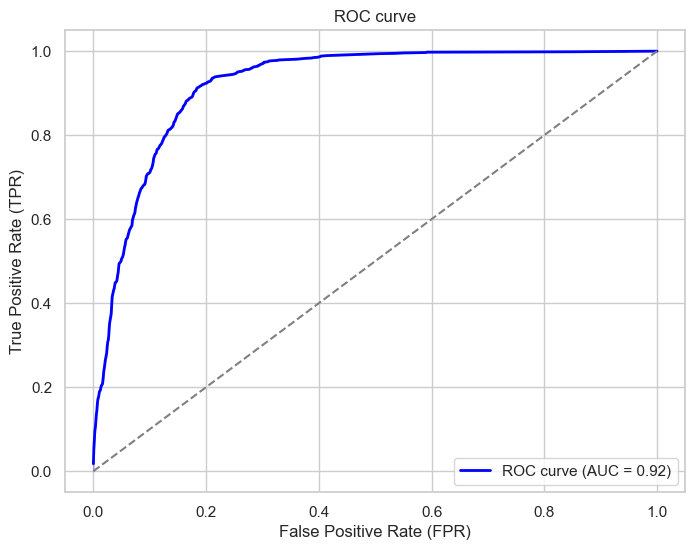

XGBoost Classifier Score: 0.9214803601306668


In [32]:
# 取得測試集的預測機率 (正類的機率)
y_prob = xgbc_clf.predict_proba(X_test_scaled)[:,1]

# 計算 ROC 曲線的真陽性率 (TPR) 和假陽性率 (FPR)
fpr, tpr, thresholds = roc_curve(y_test_split, y_prob)

# 計算 AUC 值
roc_auc = auc(fpr, tpr)

# 使用 seaborn 設定樣式
sns.set(style='whitegrid')
plt.figure(figsize=(8, 6))

# 繪製 ROC 曲線
sns.lineplot(x=fpr, y=tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

# 添加 y=x 的參考線
sns.lineplot(x=[0, 1], y=[0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print('XGBoost Classifier Score:', roc_auc_score(y_test_split, y_prob))

In [33]:
# plt 繪製 ROC curve
'''
# 取得測試集的預測機率 (正類的機率)
y_prob = xgbc_clf.predict_proba(X_test_scaled)[:,1]

# 計算 ROC 曲線的真陽性率 (TPR) 和假陽性率 (FPR)
fpr, tpr, thresholds = roc_curve(y_test_split, y_prob)

# 計算 AUC 值
roc_auc = auc(fpr, tpr)

# 繪製 ROC 曲線
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1],[0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
'''

"\n# 取得測試集的預測機率 (正類的機率)\ny_prob = xgbc_clf.predict_proba(X_test_scaled)[:,1]\n\n# 計算 ROC 曲線的真陽性率 (TPR) 和假陽性率 (FPR)\nfpr, tpr, thresholds = roc_curve(y_test_split, y_prob)\n\n# 計算 AUC 值\nroc_auc = auc(fpr, tpr)\n\n# 繪製 ROC 曲線\nplt.figure(figsize=(8, 6))\nplt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')\nplt.plot([0, 1],[0, 1], color='gray', linestyle='--')\nplt.xlabel('False Positive Rate (FPR)')\nplt.ylabel('True Positive Rate (TPR)')\nplt.title('ROC curve')\nplt.legend(loc='best')\nplt.show()\n"

## XGBoost 訓練後的特徵重要性圖

[0]	train-auc:0.85656	test-auc:0.85502
[1]	train-auc:0.87564	test-auc:0.86968
[2]	train-auc:0.88161	test-auc:0.87719
[3]	train-auc:0.88204	test-auc:0.87762
[4]	train-auc:0.88283	test-auc:0.87850
[5]	train-auc:0.88640	test-auc:0.88110
[6]	train-auc:0.88852	test-auc:0.88257
[7]	train-auc:0.89029	test-auc:0.88391
[8]	train-auc:0.89081	test-auc:0.88424
[9]	train-auc:0.89175	test-auc:0.88568
[10]	train-auc:0.89235	test-auc:0.88666
[11]	train-auc:0.89341	test-auc:0.88764
[12]	train-auc:0.89532	test-auc:0.88941
[13]	train-auc:0.89697	test-auc:0.89101
[14]	train-auc:0.89903	test-auc:0.89265
[15]	train-auc:0.90101	test-auc:0.89379
[16]	train-auc:0.90229	test-auc:0.89492
[17]	train-auc:0.90305	test-auc:0.89552
[18]	train-auc:0.90360	test-auc:0.89616
[19]	train-auc:0.90550	test-auc:0.89795
[20]	train-auc:0.90632	test-auc:0.89857
[21]	train-auc:0.90741	test-auc:0.89911
[22]	train-auc:0.91008	test-auc:0.90060
[23]	train-auc:0.91121	test-auc:0.90109
[24]	train-auc:0.91235	test-auc:0.90149
[25]	train

/var/folders/6w/6fp4bzvd51z4q5lgb62zhjph0000gn/T/ipykernel_48360/3134923708.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y=feature_importances_df.index, data=feature_importances_df, palette='Blues_r')


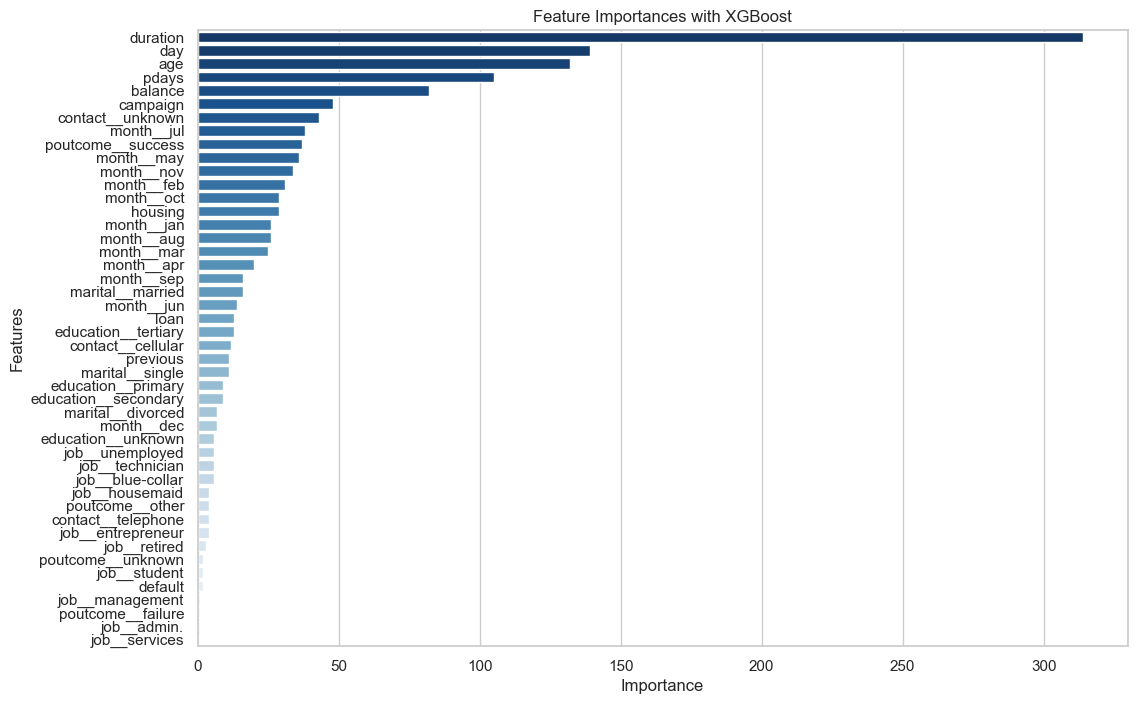

In [34]:
# 將資料轉為 DMatrix 格式以便使用 xgb.train
feature_names = X_train.columns.tolist() # 將 Index 轉換為列表
dtrain = xgb.DMatrix(data=X_train_scaled, label=y_resampled, feature_names=feature_names)
dtest = xgb.DMatrix(data=X_test_scaled, label=y_test_split, feature_names=feature_names)

# 設定參數並訓練模型
params = {
    'objective': 'binary:logistic',  # 二元分類的目標函數
    'eval_metric': 'auc',            # 評估指標
    'max_depth': 4,                  # 樹的最大深度
    'eta': 0.1                       # 學習率
}

# 訓練模型
xgboost_model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtrain, 'train'), (dtest, 'test')])

# 繪製特徵重要性
importances = xgboost_model.get_score(importance_type='weight')  # 獲取特徵重要性

# 將重要性轉換為 DataFrame 並排序
feature_importances_df = pd.DataFrame.from_dict(importances, orient='index', columns=['importance']).sort_values(by='importance', ascending=False)

# 創建新圖行
plt.figure(figsize=(12, 8))

# 使用 plt.barh() 來繪製
sns.barplot(x='importance', y=feature_importances_df.index, data=feature_importances_df, palette='Blues_r')
plt.title("Feature Importances with XGBoost")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

## Conclusion

-我們可以發現 30 歲以下，以及 60 歲以上定期存款的人數較多。
而30-60歲間且存款高於 $10,000 以上的客戶，定期存款的人數也遠高於存款低於 $10,000 的客戶。

-有房屋貸款或是個人貸款的客戶，年紀介於 30-40歲之間，因此在這個年紀間的客戶，較少的機率會定期存款。

-最好的聯繫時間最好在 350 秒以內，大約是6分鐘的時間，活動期間最好的次數為 3 次以下，若次數多反而會降低客戶定期存款的意願。